In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
data = pd.read_csv('hmda_lar.csv')

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(4408826, 47)

In [4]:
# Look at the structure of the data
data.head()

,tract_to_msamd_income,rate_spread,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,state_name,...,applicant_sex_name,applicant_race_name_5,applicant_race_name_4,applicant_race_name_3,applicant_race_name_2,applicant_race_name_1,applicant_ethnicity_name,agency_name,agency_abbr,action_taken_name
0,NaN,NaN,NaN,NaN,NaN,NaN,290,NaN,44.0,California,...,Female,NaN,NaN,NaN,NaN,White,Hispanic or Latino,Department of Housing and Urban Development,HUD,Application denied by financial institution
1,NaN,NaN,NaN,NaN,NaN,NaN,600,NaN,42.0,California,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,National Credit Union Administration,NCUA,Application denied by financial institution
2,NaN,NaN,NaN,NaN,NaN,NaN,118,NaN,43.0,California,...,Male,NaN,NaN,NaN,NaN,White,Not Hispanic or Latino,Department of Housing and Urban Development,HUD,Application denied by financial institution
3,138.410004,NaN,4323.0,83.0,996.0,1232.0,292,63000.0,141.0,California,...,Female,NaN,NaN,NaN,NaN,White,Hispanic or Latino,Office of Thrift Supervision,OTS,Loan originated
4,NaN,NaN,NaN,NaN,NaN,NaN,700,NaN,178.0,California,...,Male,NaN,NaN,NaN,NaN,Asian,Not Hispanic or Latino,National Credit Union Administration,NCUA,Application denied by financial institution


In [5]:
# Recode actions into approved or denied
new_actions = []
denied_actions = {'Application denied by financial institution'}
approved_actions = {'Loan originated','Loan purchased by the institution','Application approved but not accepted'}
for i in data['action_taken_name']:
    if i in denied_actions:
        new_actions.append('Denied')
    else:
        if i in approved_actions:
            new_actions.append('Approved')
        else: new_actions.append(None)

In [6]:
# Recode race and ethnicity into minority or non-minority
minority = []
for i in range(data.shape[0]):
    result = None
    if data['applicant_ethnicity_name'][i] == 'Hispanic or Latino':
        result = 'Yes'
    if data['applicant_race_name_1'][i] != 'White':
        result = 'Yes'
    else:
        if data['applicant_race_name_1'][i] == 'White' and data['applicant_ethnicity_name'][i] == 'Not Hispanic or Latino':
                result = 'No'
    minority.append(result)

In [7]:
# Append results to the dataset
data['Minority'] = minority
data['actions_new'] = new_actions

In [8]:
# For convenience, export results of recoding to csv
data[['Minority','actions_new']].to_csv('addCol.csv')

In [4]:
# Read from exported csv and append to dataset
addCol = pd.read_csv('addCol.csv')

data['actions_new'] = addCol['actions_new']
data['Minority'] = addCol['Minority']

In [10]:
# Overall
data[['Minority','actions_new']].groupby(['Minority','actions_new']).size()

Minority  actions_new
No        Approved       2349563
          Denied          425602
Yes       Approved       1301539
          Denied          332122
dtype: int64

In [11]:
# Texas
data[['Minority','actions_new']].loc[data['state_name']=='Texas'].groupby(['Minority','actions_new']).size()

Minority  actions_new
No        Approved       917813
          Denied         168044
Yes       Approved       404961
          Denied         134828
dtype: int64

In [12]:
# California
data[['Minority','actions_new']].loc[data['state_name']=='California'].groupby(['Minority','actions_new']).size()

Minority  actions_new
No        Approved       1431750
          Denied          257558
Yes       Approved        896578
          Denied          197294
dtype: int64

In [16]:
# Look at missing values
data.isnull().sum()

tract_to_msamd_income              16339
population                         15557
minority_population                15686
number_of_owner_occupied_units     17508
number_of_1_to_4_family_units      15936
loan_amount_000s                       0
hud_median_family_income           14960
applicant_income_000s             257826
state_abbr                             0
purchaser_type_name                    0
property_type_name                     0
preapproval_name                       0
owner_occupancy_name                   0
loan_type_name                         0
loan_purpose_name                      0
lien_status_name                       0
hoepa_status_name                      0
co_applicant_sex_name                  0
co_applicant_race_name_1               0
co_applicant_ethnicity_name            0
as_of_year                             0
application_date_indicator             0
applicant_sex_name                     0
applicant_race_name_1                  0
applicant_ethnic

In [15]:
# Delete meanlingless variables
data = data.drop(['rate_spread','edit_status_name','denial_reason_name_3','denial_reason_name_2','denial_reason_name_1',
                 'co_applicant_race_name_5','co_applicant_race_name_4','co_applicant_race_name_3','co_applicant_race_name_2',
                 'applicant_race_name_5','applicant_race_name_4','applicant_race_name_3','applicant_race_name_2',
                 'respondent_id','census_tract_number','msamd_name','county_name','sequence_number','state_name',
                 'action_taken_name','agency_name'],axis=1)

In [17]:
# Feature engineering
data['minority_ratio'] = data['minority_population']/data['population']
data['tract_median_income'] = data['tract_to_msamd_income'] * data['hud_median_family_income']
data['income_to_loan'] = data['applicant_income_000s'] / data['loan_amount_000s']

In [8]:
# For future
data = data.dropna(subset = ['census_tract_number'])
data = data.dropna(subset = ['county_name'])

data['tract_uni'] = data['census_tract_number'].astype(str) + '-' + data['county_name'] + '-' + data['state_abbr']

In [18]:
# Define training data for modeling
train = data[['tract_median_income','number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'income_to_loan',
       'state_abbr', 'property_type_name',
       'preapproval_name', 'owner_occupancy_name', 'loan_type_name',
       'loan_purpose_name', 'lien_status_name', 'hoepa_status_name',
       'co_applicant_sex_name','as_of_year','applicant_sex_name','agency_abbr','minority_ratio','actions_new']]

In [19]:
train = train.dropna()

In [20]:
train = pd.get_dummies(train)

In [22]:
train.head()

,tract_median_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,income_to_loan,as_of_year,minority_ratio,state_abbr_CA,state_abbr_TX,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),...,applicant_sex_name_Male,agency_abbr_CFPB,agency_abbr_FDIC,agency_abbr_FRS,agency_abbr_HUD,agency_abbr_NCUA,agency_abbr_OCC,agency_abbr_OTS,actions_new_Approved,actions_new_Denied
3,8.719830e+06,996.0,1232.0,0.482877,2010,0.019200,1,0,0,1,...,0,0,0,0,0,0,0,1,1,0
13,9.863469e+06,1065.0,1381.0,0.136054,2010,0.006228,1,0,0,1,...,1,0,0,0,0,0,1,0,1,0
18,8.673315e+06,858.0,1488.0,0.392739,2010,0.006639,1,0,0,1,...,1,0,0,0,0,0,1,0,1,0
23,8.227233e+06,1519.0,1964.0,0.592105,2010,0.005860,1,0,0,1,...,1,0,0,0,0,0,1,0,1,0
28,1.503676e+07,1927.0,2241.0,0.411379,2010,0.003975,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [25]:
y = train.iloc[:,44]
y.head()

3     1
13    1
18    1
23    1
28    1
Name: actions_new_Approved, dtype: uint8

In [27]:
X = train.iloc[:,0:44]

X.head()

,tract_median_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,income_to_loan,as_of_year,minority_ratio,state_abbr_CA,state_abbr_TX,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),...,applicant_sex_name_Female,"applicant_sex_name_Information not provided by applicant in mail, Internet, or telephone application",applicant_sex_name_Male,agency_abbr_CFPB,agency_abbr_FDIC,agency_abbr_FRS,agency_abbr_HUD,agency_abbr_NCUA,agency_abbr_OCC,agency_abbr_OTS
3,8.719830e+06,996.0,1232.0,0.482877,2010,0.019200,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
13,9.863469e+06,1065.0,1381.0,0.136054,2010,0.006228,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
18,8.673315e+06,858.0,1488.0,0.392739,2010,0.006639,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
23,8.227233e+06,1519.0,1964.0,0.592105,2010,0.005860,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
28,1.503676e+07,1927.0,2241.0,0.411379,2010,0.003975,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0


In [21]:
train.shape

(4133500, 46)

In [102]:
mino = data.loc[data['Minority'] == 'Yes']
majo = data.loc[data['Minority'] == 'No']
mino['applicant_income_000s'].describe()

count    1.597741e+06
mean     1.008917e+02
std      1.215228e+02
min      1.000000e+00
25%      4.900000e+01
50%      7.700000e+01
75%      1.220000e+02
max      9.999000e+03
Name: applicant_income_000s, dtype: float64

In [103]:
majo['applicant_income_000s'].describe()

count    2.606991e+06
mean     1.352630e+02
std      1.915382e+02
min      1.000000e+00
25%      6.400000e+01
50%      9.900000e+01
75%      1.520000e+02
max      9.999000e+03
Name: applicant_income_000s, dtype: float64

In [104]:
mino['loan_amount_000s'].describe()

count    1.709227e+06
mean     2.414074e+02
std      1.869450e+02
min      1.000000e+00
25%      1.200000e+02
50%      2.000000e+02
75%      3.200000e+02
max      1.400000e+04
Name: loan_amount_000s, dtype: float64

In [105]:
majo['loan_amount_000s'].describe()

count    2.759894e+06
mean     2.763878e+02
std      2.567693e+02
min      1.000000e+00
25%      1.340000e+02
50%      2.200000e+02
75%      3.550000e+02
max      7.600000e+04
Name: loan_amount_000s, dtype: float64

In [9]:
data['income_to_loan'] = data['applicant_income_000s'] / data['loan_amount_000s']

(4441455,)


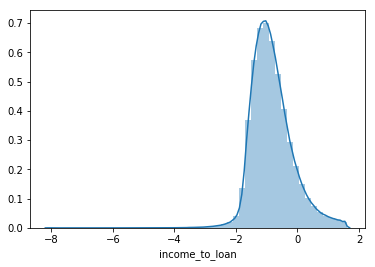

In [17]:
plot = data.loc[data['income_to_loan']<5]['income_to_loan']
print(plot.shape)
sns.distplot(np.log(plot))

In [76]:
data['co_applicant_race_name_1'].value_counts()

No co-applicant                                                                      2326137
White                                                                                1843634
Asian                                                                                 332660
Information not provided by applicant in mail, Internet, or telephone application     213522
Black or African American                                                              61649
Native Hawaiian or Other Pacific Islander                                              18466
American Indian or Alaska Native                                                       16967
Not applicable                                                                          3581
Name: co_applicant_race_name_1, dtype: int64

In [25]:
data = data.dropna(subset = ['Minority'])

In [26]:
data = data.dropna(subset = ['actions_new'])

In [27]:
data.shape

(4170109, 49)

In [12]:
data.isnull().sum()

tract_to_msamd_income              17644
population                         16850
minority_population                16980
number_of_owner_occupied_units     18842
number_of_1_to_4_family_units      17234
loan_amount_000s                       0
hud_median_family_income           16242
applicant_income_000s             264693
state_abbr                             0
purchaser_type_name                    0
property_type_name                     0
preapproval_name                       0
owner_occupancy_name                   0
loan_type_name                         0
loan_purpose_name                      0
lien_status_name                       0
hoepa_status_name                      0
co_applicant_sex_name                  0
co_applicant_race_name_1               0
co_applicant_ethnicity_name            0
as_of_year                             0
application_date_indicator             0
applicant_sex_name                     0
applicant_race_name_1                  0
applicant_ethnic

In [6]:
data['actions_new'] = new_actions

In [3]:
data_simple = data

In [14]:
data.columns

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s',
       'state_abbr', 'purchaser_type_name', 'property_type_name',
       'preapproval_name', 'owner_occupancy_name', 'loan_type_name',
       'loan_purpose_name', 'lien_status_name', 'hoepa_status_name',
       'co_applicant_sex_name', 'co_applicant_race_name_1',
       'co_applicant_ethnicity_name', 'as_of_year',
       'application_date_indicator', 'applicant_sex_name',
       'applicant_race_name_1', 'applicant_ethnicity_name', 'agency_abbr',
       'actions_new', 'Minority', 'minority_ratio'],
      dtype='object')

In [34]:
y.head()

3     1
13    1
18    1
28    1
38    1
Name: actions_new_Approved, dtype: uint8

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X.iloc[:,0:7])
X.iloc[:,0:7] = scaler.transform(X.iloc[:,0:7])

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt

In [38]:
train.corr()['actions_new_Approved']

tract_median_income                                                                                        0.081936
number_of_owner_occupied_units                                                                             0.030189
number_of_1_to_4_family_units                                                                              0.012192
income_to_loan                                                                                            -0.050155
as_of_year                                                                                                -0.003450
minority_ratio                                                                                            -0.043107
state_abbr_CA                                                                                              0.029922
state_abbr_TX                                                                                             -0.029922
property_type_name_Manufactured housing                                 

In [36]:
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[  1.07355805e-01   9.95428463e-02   9.95647475e-02   4.67863060e-01
   5.04483918e-03   1.02226724e-01   2.71755174e-03   2.23932785e-03
   4.68683790e-03   3.80221599e-03   7.65953287e-04   9.31645990e-04
   4.13747217e-04   1.49813049e-04   1.20440915e-03   1.26632283e-03
   3.87355771e-03   2.90007260e-03   1.65945268e-04   6.37506612e-04
   8.42326929e-03   8.37592162e-03   1.93834071e-03   2.76921566e-02
   4.37114029e-03   1.02964631e-02   1.79880340e-03   1.78776933e-05
   1.90399496e-05   4.78910967e-03   3.69124012e-04   1.96489467e-03
   2.39578654e-03   5.74076786e-05   1.74282027e-03   1.11385880e-03
   2.32867139e-03   1.70535246e-03   1.25299381e-03   3.86752814e-03
   2.42332561e-03   4.79576487e-03   9.07420035e-04]


In [37]:
importances = []
for i in range(len(X.columns)):
    importances.append((X.columns[i],model.feature_importances_[i]))
importances_sorted = sorted(importances, key=lambda tup: tup[1])
importances_sorted

[('hoepa_status_name_HOEPA loan', 1.7877693259116443e-05),
 ('hoepa_status_name_Not a HOEPA loan', 1.9039949573270626e-05),
 ('co_applicant_sex_name_Not applicable', 5.7407678575196902e-05),
 ('owner_occupancy_name_Not applicable', 0.00014981304932181312),
 ('loan_type_name_FSA/RHS-guaranteed', 0.00016594526789682037),
 ('co_applicant_sex_name_Information not provided by applicant in mail, Internet, or telephone application',
  0.00036912401155140726),
 ('preapproval_name_Preapproval was requested', 0.00041374721692998272),
 ('loan_type_name_VA-guaranteed', 0.00063750661175228786),
 ('preapproval_name_Not applicable', 0.00076595328737104297),
 ('agency_abbr_OTS', 0.00090742003547870649),
 ('preapproval_name_Preapproval was not requested', 0.00093164598950327938),
 ('applicant_sex_name_Male', 0.0011138588016512188),
 ('owner_occupancy_name_Not owner-occupied as a principal dwelling',
  0.0012044091502733645),
 ('agency_abbr_FRS', 0.0012529938109412313),
 ('owner_occupancy_name_Owner-occ

In [63]:
data['population'].describe()

count    4.797319e+06
mean     5.995923e+03
std      3.195333e+03
min      1.000000e+00
25%      4.047000e+03
50%      5.404000e+03
75%      7.050000e+03
max      3.745200e+04
Name: population, dtype: float64

In [39]:
further = data[['income_to_loan',
    'tract_median_income','number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'applicant_income_000s','loan_purpose_name','lien_status_name','Minority','minority_ratio','actions_new']]

In [40]:
further = further.dropna()

In [41]:
further = pd.get_dummies(further)

In [9]:
further.columns

Index(['tract_median_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'loan_amount_000s',
       'applicant_income_000s', 'minority_ratio',
       'loan_purpose_name_Home improvement', 'loan_purpose_name_Home purchase',
       'loan_purpose_name_Refinancing', 'lien_status_name_Not applicable',
       'lien_status_name_Not secured by a lien',
       'lien_status_name_Secured by a first lien',
       'lien_status_name_Secured by a subordinate lien', 'Minority_No',
       'Minority_Yes', 'actions_new_Approved', 'actions_new_Denied'],
      dtype='object')

In [42]:
further = further[['income_to_loan','tract_median_income', 'number_of_owner_occupied_units',
       'number_of_1_to_4_family_units', 'loan_amount_000s',
       'applicant_income_000s', 'minority_ratio','loan_purpose_name_Home improvement',
       'loan_purpose_name_Home purchase', 'loan_purpose_name_Refinancing',
       'lien_status_name_Not applicable',
       'lien_status_name_Not secured by a lien',
       'lien_status_name_Secured by a first lien',
       'lien_status_name_Secured by a subordinate lien', 'Minority_No',
       'Minority_Yes', 'actions_new_Approved']]

In [43]:
further.corr()[['actions_new_Approved','Minority_Yes']]

,actions_new_Approved,Minority_Yes
income_to_loan,-0.050155,-0.001200
tract_median_income,0.081936,-0.153780
number_of_owner_occupied_units,0.030189,-0.074642
number_of_1_to_4_family_units,0.012192,-0.074055
loan_amount_000s,0.040317,-0.073986
applicant_income_000s,0.037618,-0.098670
minority_ratio,-0.043107,0.230333
loan_purpose_name_Home improvement,-0.130555,0.018159
loan_purpose_name_Home purchase,0.120990,0.067852
loan_purpose_name_Refinancing,-0.067582,-0.074152


In [44]:
control = data[['as_of_year','state_abbr','loan_amount_000s','applicant_income_000s','tract_uni','Minority','actions_new']]

In [45]:
control = control.dropna()

In [46]:
control.shape

(4204732, 7)

In [57]:
new = pd.get_dummies(control['actions_new'])
control['actions_new_Approved'] = new['Approved']

In [161]:
control['tract_uni'].value_counts()[0:4000].sum()

2459578

In [162]:
control['tract_uni'].value_counts()[4000]

355

In [26]:
control['tract_uni'].value_counts()

305.03-Collin County-TX            5564
6731.01-Fort Bend County-TX        5091
3551.04-Contra Costa County-CA     4935
6729.0-Fort Bend County-TX         4785
6731.0-Fort Bend County-TX         4682
201.02-Denton County-TX            4366
314.01-Collin County-TX            3717
170.3-San Diego County-CA          3513
103.2-El Paso County-TX            3206
406.02-Riverside County-CA         3202
1139.14-Tarrant County-TX          3108
305.02-Collin County-TX            2959
6734.0-Fort Bend County-TX         2930
6906.0-Montgomery County-TX        2914
17.6-Travis County-TX              2835
1139.13-Tarrant County-TX          2803
5430.0-Harris County-TX            2755
1918.05-Bexar County-TX            2738
524.2-Orange County-CA             2729
217.14-Denton County-TX            2656
6920.0-Montgomery County-TX        2545
133.1-San Diego County-CA          2523
96.04-Sacramento County-CA         2435
133.13-San Diego County-CA         2428
17.32-Travis County-TX             2418


In [135]:
small = control.iloc[0:1000,:]

In [136]:
ttest_ind(small['loan_amount_000s'],small['applicant_income_000s'])

Ttest_indResult(statistic=36.951364027585683, pvalue=3.0885223608152163e-228)

In [120]:
test = control

In [121]:
top_tracts = test['tract_uni'].value_counts()[0:4000].index.tolist()

In [122]:
# Base
result = []
result_weighted = []
total = 0
for i in top_tracts:
    subset = test.loc[test['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    
    total += num
    if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
        result.append(1)
        result_weighted.append(len(subset))
    else:
        result.append(0)
        result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

4000
0.7655
0.771448191519


In [95]:
# Two states, tracts number = 4000, two years

result = []
result_weighted = []
total = 0
for i in top_tracts:
    subset = test.loc[test['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    minority = minority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    majority = majority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    
    flag = 0
    while flag == 0 and len(majority) > 30 and len(minority) > 30:
        income_minority = np.log(minority['applicant_income_000s'] * 1000)
        income_majority = np.log(majority['applicant_income_000s'] * 1000)
        amount_minority = np.log(minority['loan_amount_000s'] * 1000)
        amount_majority = np.log(majority['loan_amount_000s'] * 1000)
        t1, p_income = ttest_ind(income_minority, income_majority, equal_var=False)
        t2, p_amount = ttest_ind(amount_minority, amount_majority, equal_var=False)
        if p_income<0.2 or p_amount<0.1:
            mean_minority = income_minority.mean()
            mean_majority = income_majority.mean()
            if mean_majority > mean_minority:
                majority = majority[:-1]
            else: 
                majority = majority[1:]
        else:
            flag = 1
            
    if flag == 1:
        total += num
        if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
            result.append(1)
            result_weighted.append(len(subset))
        else:
            result.append(0)
            result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

3721
0.777479172266
0.790854054696


In [106]:
test_TX = control.loc[control['state_abbr'] == 'TX']

In [107]:
test_TX.shape

(1539266, 8)

In [53]:
test_TX['tract_uni'].value_counts()[0:2000].sum()

1096592

In [108]:
top_tracts_TX = test_TX['tract_uni'].value_counts()[0:2000].index.tolist()

In [109]:
# TX, two years, 2000 tracts

result = []
result_weighted = []
total = 0

for i in top_tracts_TX:
    subset = test_TX.loc[test_TX['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    minority = minority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    majority = majority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    
    flag = 0
    while flag == 0 and len(majority) > 30 and len(minority) > 30:
        income_minority = np.log(minority['applicant_income_000s'] * 1000)
        income_majority = np.log(majority['applicant_income_000s'] * 1000)
        amount_minority = np.log(minority['loan_amount_000s'] * 1000)
        amount_majority = np.log(majority['loan_amount_000s'] * 1000)
        t1, p_income = ttest_ind(income_minority, income_majority, equal_var=False)
        t2, p_amount = ttest_ind(amount_minority, amount_majority, equal_var=False)
        if p_income<0.2 or p_amount<0.2:
            mean_minority = income_minority.mean()
            mean_majority = income_majority.mean()
            if mean_majority > mean_minority:
                majority = majority[:-1]
            else: 
                majority = majority[1:]
        else:
            flag = 1
            
    if flag == 1:
        total += num
        if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
            result.append(1)
            result_weighted.append(len(subset))
        else:
            result.append(0)
            result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

1553
0.871216999356
0.889337840357


In [110]:
test_CA = control.loc[control['state_abbr'] == 'CA']

In [63]:
test_CA.shape

(2665466, 8)

In [81]:
test_CA['tract_uni'].value_counts()[0:3000].sum()

1680519

In [75]:
test_TX['tract_uni'].value_counts()[3500]

129

In [111]:
top_tracts_CA = test_CA['tract_uni'].value_counts()[0:3500].index.tolist()

In [112]:
# CA, two years, 3500 tracts

result = []
result_weighted = []
total = 0

for i in top_tracts_CA:
    subset = test_CA.loc[test_CA['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    minority = minority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    majority = majority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    
    flag = 0
    while flag == 0 and len(majority) > 30 and len(minority) > 30:
        income_minority = np.log(minority['applicant_income_000s'] * 1000)
        income_majority = np.log(majority['applicant_income_000s'] * 1000)
        amount_minority = np.log(minority['loan_amount_000s'] * 1000)
        amount_majority = np.log(majority['loan_amount_000s'] * 1000)
        t1, p_income = ttest_ind(income_minority, income_majority, equal_var=False)
        t2, p_amount = ttest_ind(amount_minority, amount_majority, equal_var=False)
        if p_income<0.2 or p_amount<0.2:
            mean_minority = income_minority.mean()
            mean_majority = income_majority.mean()
            if mean_majority > mean_minority:
                majority = majority[:-1]
            else: 
                majority = majority[1:]
        else:
            flag = 1
            
    if flag == 1:
        total += num
        if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
            result.append(1)
            result_weighted.append(len(subset))
        else:
            result.append(0)
            result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

2996
0.742990654206
0.74601594745


In [85]:
test_10 = control.loc[control['as_of_year'] == 2010]

In [86]:
test_10.shape

(2015743, 8)

In [90]:
test_10['tract_uni'].value_counts()[0:3000].sum()

1235864

In [91]:
top_tracts_10 = test_10['tract_uni'].value_counts()[0:3000].index.tolist()

In [113]:
result = []
result_weighted = []
total = 0

for i in top_tracts_10:
    subset = test_10.loc[test_10['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    minority = minority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    majority = majority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    
    flag = 0
    while flag == 0 and len(majority) > 30 and len(minority) > 30:
        income_minority = np.log(minority['applicant_income_000s'] * 1000)
        income_majority = np.log(majority['applicant_income_000s'] * 1000)
        amount_minority = np.log(minority['loan_amount_000s'] * 1000)
        amount_majority = np.log(majority['loan_amount_000s'] * 1000)
        t1, p_income = ttest_ind(income_minority, income_majority, equal_var=False)
        t2, p_amount = ttest_ind(amount_minority, amount_majority, equal_var=False)
        if p_income<0.2 or p_amount<0.2:
            mean_minority = income_minority.mean()
            mean_majority = income_majority.mean()
            if mean_majority > mean_minority:
                majority = majority[:-1]
            else: 
                majority = majority[1:]
        else:
            flag = 1
            
    if flag == 1:
        total += num
        if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
            result.append(1)
            result_weighted.append(len(subset))
        else:
            result.append(0)
            result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

2218
0.720468890893
0.763049663299


In [114]:
test_13 = control.loc[control['as_of_year'] == 2013]

In [115]:
top_tracts_13 = test_13['tract_uni'].value_counts()[0:3000].index.tolist()

In [116]:
result = []
result_weighted = []
total = 0

for i in top_tracts_13:
    subset = test_13.loc[test_13['tract_uni']==i]
    num = len(subset)
    minority = subset.loc[subset['Minority']=='Yes']
    majority = subset.loc[subset['Minority']=='No']
    minority = minority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    majority = majority.sort_values(by=['applicant_income_000s','loan_amount_000s'])
    
    flag = 0
    while flag == 0 and len(majority) > 30 and len(minority) > 30:
        income_minority = np.log(minority['applicant_income_000s'] * 1000)
        income_majority = np.log(majority['applicant_income_000s'] * 1000)
        amount_minority = np.log(minority['loan_amount_000s'] * 1000)
        amount_majority = np.log(majority['loan_amount_000s'] * 1000)
        t1, p_income = ttest_ind(income_minority, income_majority, equal_var=False)
        t2, p_amount = ttest_ind(amount_minority, amount_majority, equal_var=False)
        if p_income<0.2 or p_amount<0.2:
            mean_minority = income_minority.mean()
            mean_majority = income_majority.mean()
            if mean_majority > mean_minority:
                majority = majority[:-1]
            else: 
                majority = majority[1:]
        else:
            flag = 1
            
    if flag == 1:
        total += num
        if minority['actions_new_Approved'].mean() < majority['actions_new_Approved'].mean():
            result.append(1)
            result_weighted.append(len(subset))
        else:
            result.append(0)
            result_weighted.append(0)
result = np.array(result)
result_weighted = np.array(result_weighted)
print (len(result))
print(np.mean(result))
print(np.sum(result_weighted)/total)

2374
0.781381634372
0.792229561018


In [117]:
base = control[['Minority','tract_uni','actions_new_Approved']]
base.head()

,Minority,tract_uni,actions_new_Approved
3,Yes,5545.11-Los Angeles County-CA,1
13,No,4503.0-Alameda County-CA,1
18,No,3570.0-Contra Costa County-CA,1
28,No,3300.0-Contra Costa County-CA,1
38,Yes,3451.1-Contra Costa County-CA,1


In [119]:
control['Minority']

tract_uni
1.0-Amador County-CA        331
1.0-Angelina County-TX      190
1.0-Brazos County-TX        730
1.0-Calhoun County-TX       107
1.0-Colusa County-CA        209
1.0-Cooke County-TX         136
1.0-Dallas County-TX        615
1.0-Ector County-TX         114
1.0-Freestone County-TX     130
1.0-Fresno County-CA         10
1.0-Gonzales County-TX       37
1.0-Humboldt County-CA      115
1.0-Inyo County-CA          124
1.0-Kings County-CA         145
1.0-Lake County-CA          162
1.0-Lamar County-TX          98
1.0-Lavaca County-TX         58
1.0-Lee County-TX           134
1.0-Lubbock County-TX       107
1.0-Madison County-TX        17
1.0-Mariposa County-CA      126
1.0-McLennan County-TX       21
1.0-Merced County-CA          8
1.0-Midland County-TX       372
1.0-Modoc County-CA         125
1.0-Mono County-CA          298
1.0-Nueces County-TX         16
1.0-Palo Pinto County-TX    133
1.0-Plumas County-CA        319
1.0-Sacramento County-CA    412
                           ...